In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('MNRAS')
import fitsio

In [2]:
boxsize = 1000 * 0.681
rmax_tree = 2
from scipy import spatial

In [3]:
loc = '/cosma8/data/do012/dc-wu5/cylinder/output_L1000N3600/HYDRO_FIDUCIAL/'

def plot_hod(halo_finder, gal_selection):
    plt.figure()
    #den_wanted=1e-3
    #gal_selection = 'model_redmagic_chi6_1e-02_HBT'
    
    ### read the halo catalog
    halo_fname = loc + f'host_halos_0072_{halo_finder}_M200m_1e+11.fit'
    data = fitsio.read(halo_fname)
    x_halo = data['px']
    y_halo = data['py']
    z_halo = data['pz']
    M200m_halo = data['M200m']
    R200m_halo = data['R200m']

    #### read the galaxy catalog
    gal_fname = loc + f'model_{gal_selection}_{halo_finder}/gals.fit'
    data_gal = fitsio.read(gal_fname)
    x_gal = data_gal['px']
    y_gal = data_gal['py']
    z_gal = data_gal['pz']


    gal_position = np.dstack([x_gal, y_gal, z_gal])[0]
    gal_tree = spatial.cKDTree(gal_position, boxsize=boxsize)
    
    halo_position = np.dstack([x_halo, y_halo, z_halo])[0]
    halo_tree = spatial.cKDTree(halo_position, boxsize=boxsize)
    indexes_tree = halo_tree.query_ball_tree(gal_tree, r=rmax_tree)


    Ncen = []
    Ngal = []
    for i_halo in range(len(x_halo)):
        gal_ind = indexes_tree[i_halo]
        x_cen = x_halo[i_halo]
        y_cen = y_halo[i_halo]
        z_cen = z_halo[i_halo]
        R200m = R200m_halo[i_halo]
        M200m = M200m_halo[i_halo]
        indx = gal_tree.query_ball_point([x_cen, y_cen, z_cen], R200m)
        Ngal.append(len(indx))
    
        indx = gal_tree.query_ball_point([x_cen, y_cen, z_cen], 1e-6)
        Ncen.append(len(indx))

    Ncen = np.array(Ncen)
    Ngal = np.array(Ngal)

    def calc_mean(x, y):
        nbins_per_decade = 10
        n_decade = (max(x) - min(x))/np.log(10)
        nbins = int(nbins_per_decade*n_decade + 1e-4) 
        x_bins = np.linspace(min(x), max(x), nbins+1)
        x_bin_mean = []
        y_bin_mean = []
        y_bin_std = []
        for i in range(nbins):
            sel = (x > x_bins[i])&(x < x_bins[i+1])
            x_bin_mean.append(np.mean(x[sel]))
            y_bin_mean.append(np.mean(y[sel]))
            y_bin_std.append(np.std(y[sel]))
        
        y_bin_mean = np.array(y_bin_mean)
        y_bin_std = np.array(y_bin_std)
        return x_bin_mean, y_bin_mean, y_bin_std

    lnM, Ncen_mean, Ncen_std = calc_mean(np.log(M200m_halo), Ncen)
    lnM, Nsat_mean, Nsat_std = calc_mean(np.log(M200m_halo), Ngal-Ncen)
    lnM, Ngal_mean, Ngal_std = calc_mean(np.log(M200m_halo), Ngal)
    
    
    plt.plot(np.exp(lnM), Ncen_mean)
    plt.plot(np.exp(lnM), Nsat_mean)
    plt.plot(np.exp(lnM), Ngal_mean)
    plt.ylim(1e-2, None)
    plt.loglog()
    plt.xlabel(r'$\rm M_{200m} ~[h^{-1}M_\odot]$')
    plt.ylabel(r'$\rm N_{gal}$')
    plt.title(f'{gal_selection.replace('_','-')} {halo_finder}')
    plt.savefig(f'../../plots/validation/hod/hod_{gal_selection}_{halo_finder}.png')

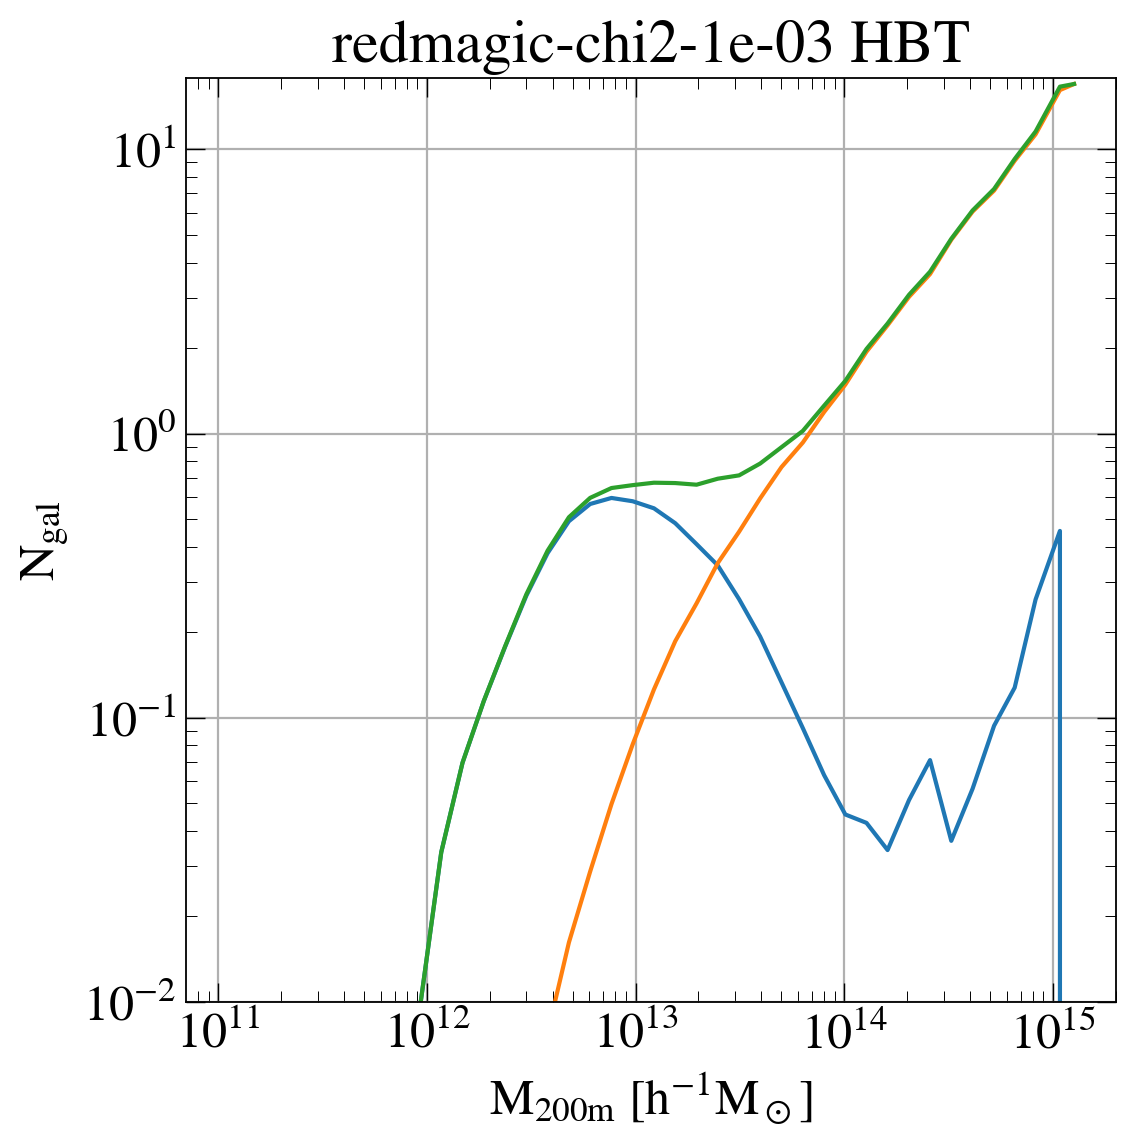

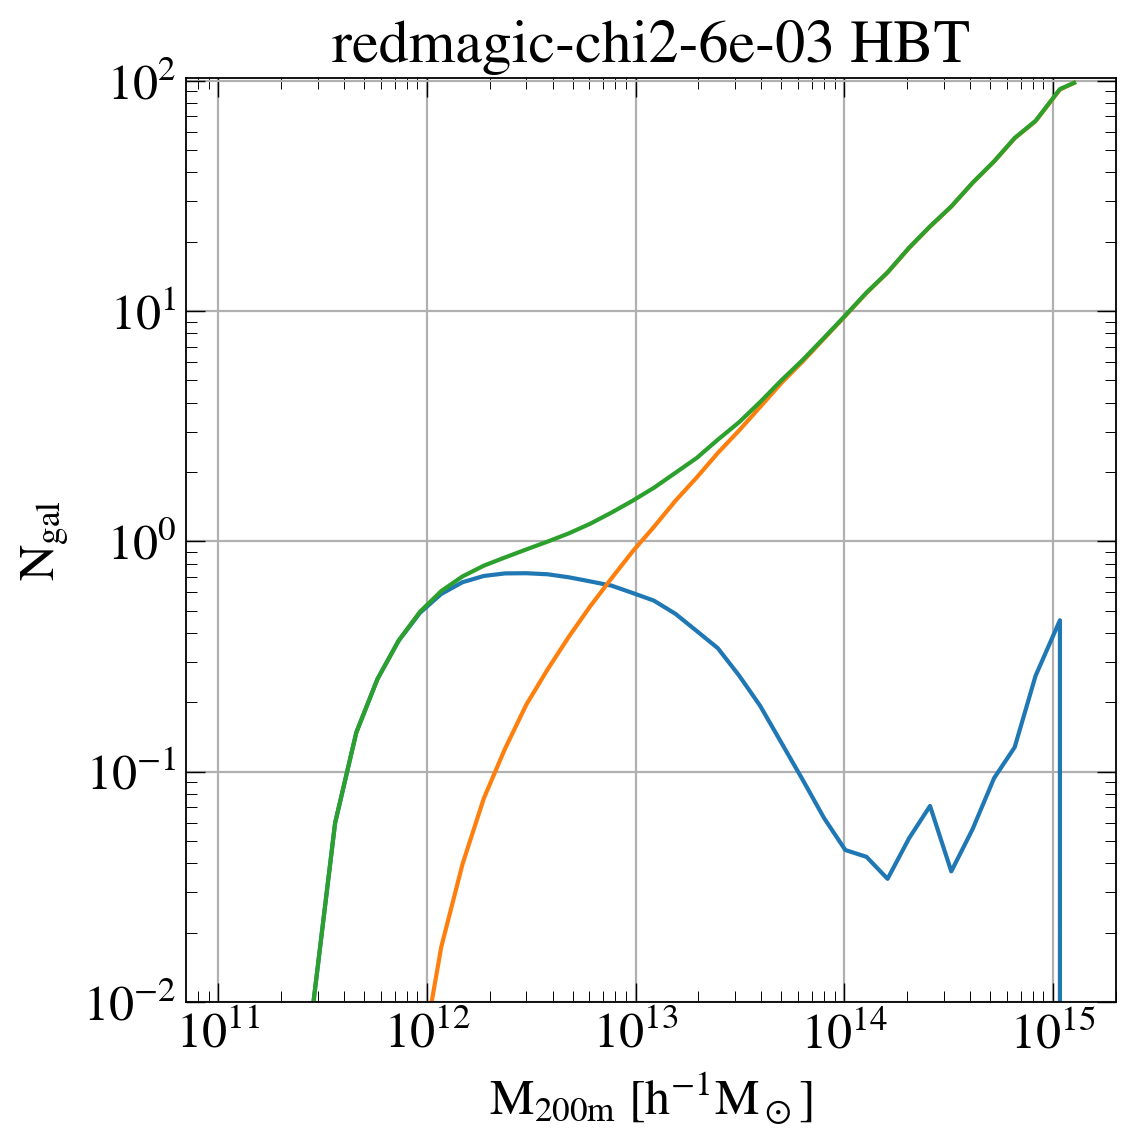

In [4]:
for halo_finder in ['HBT']:
    for den_wanted in [1e-3, 6e-3]: 
        gal_selection = f'redmagic_chi2_{den_wanted:.0e}'
        plot_hod(halo_finder, gal_selection)

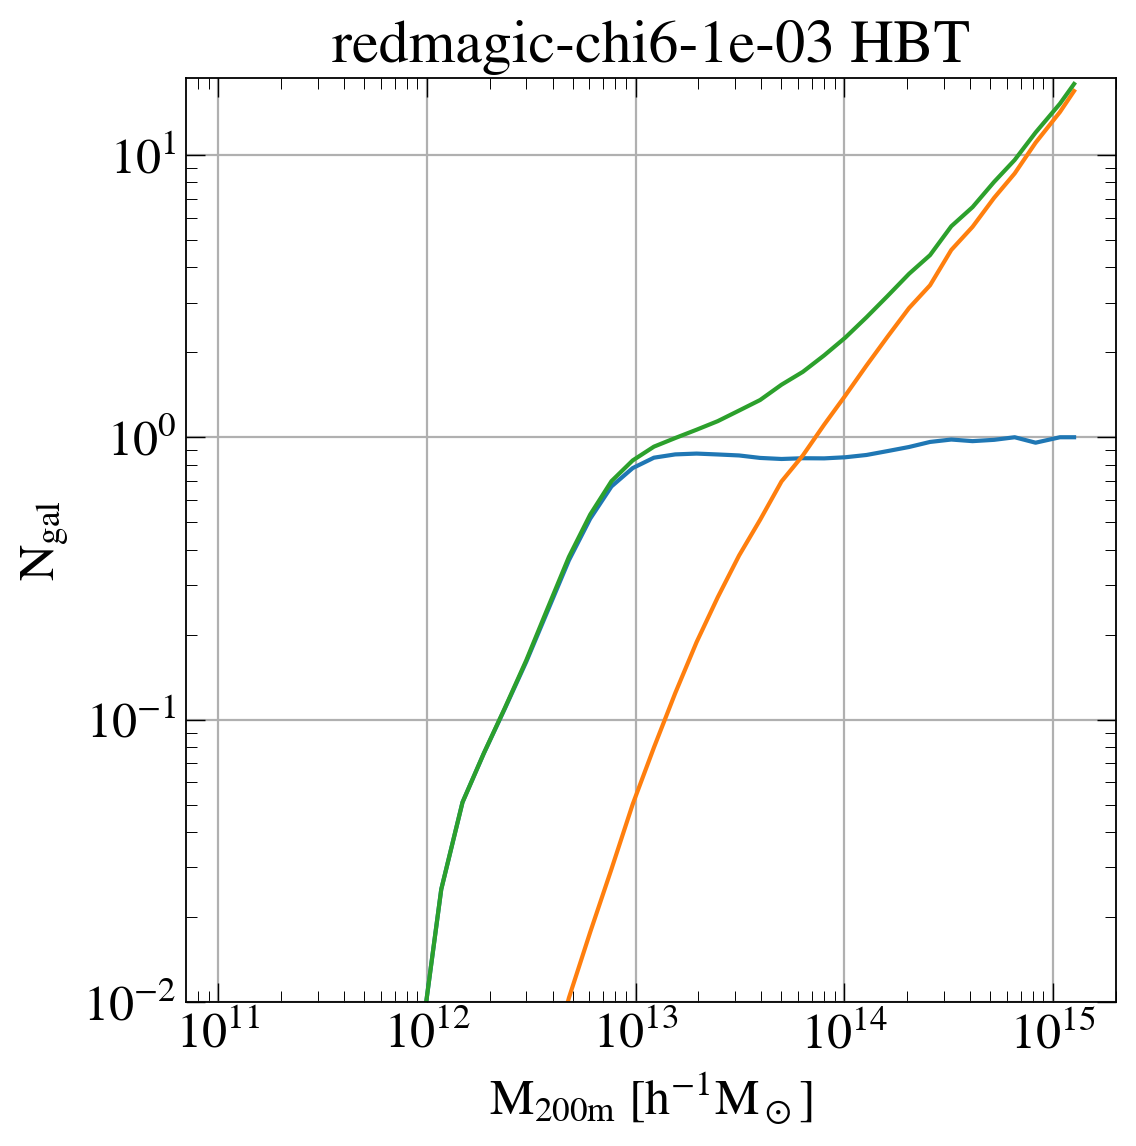

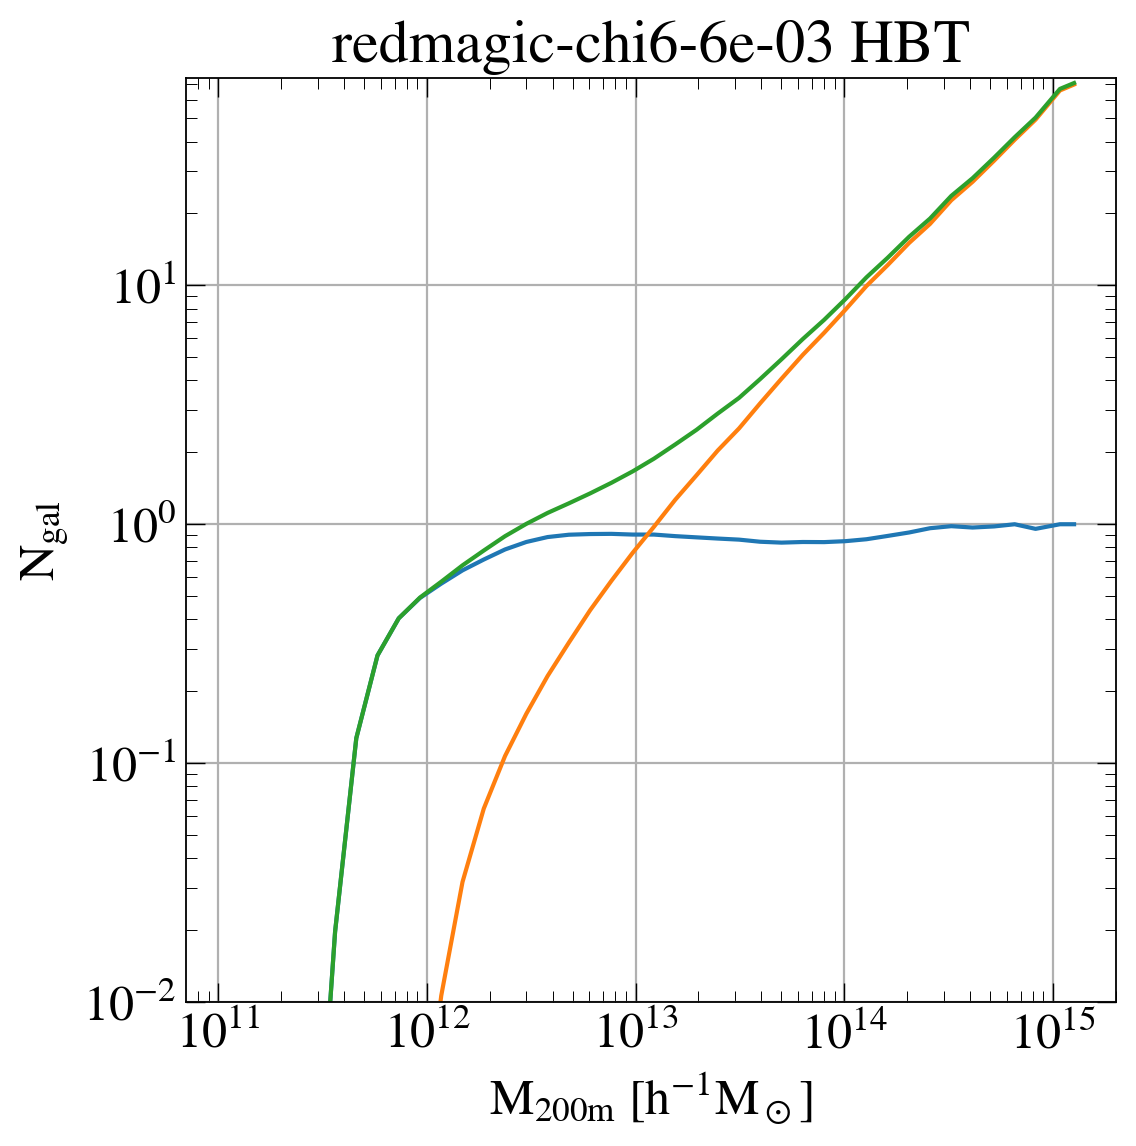

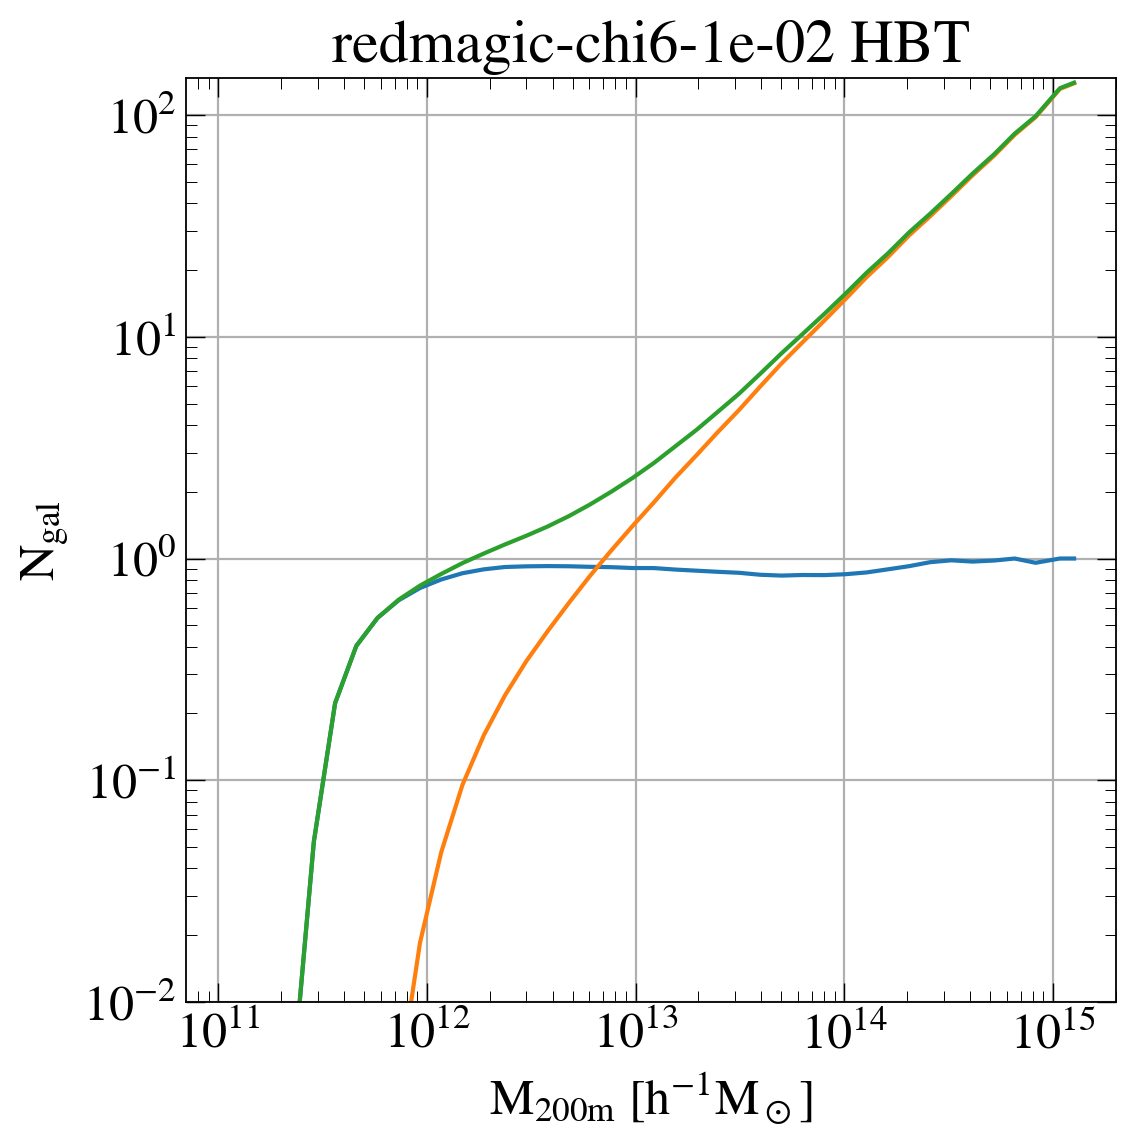

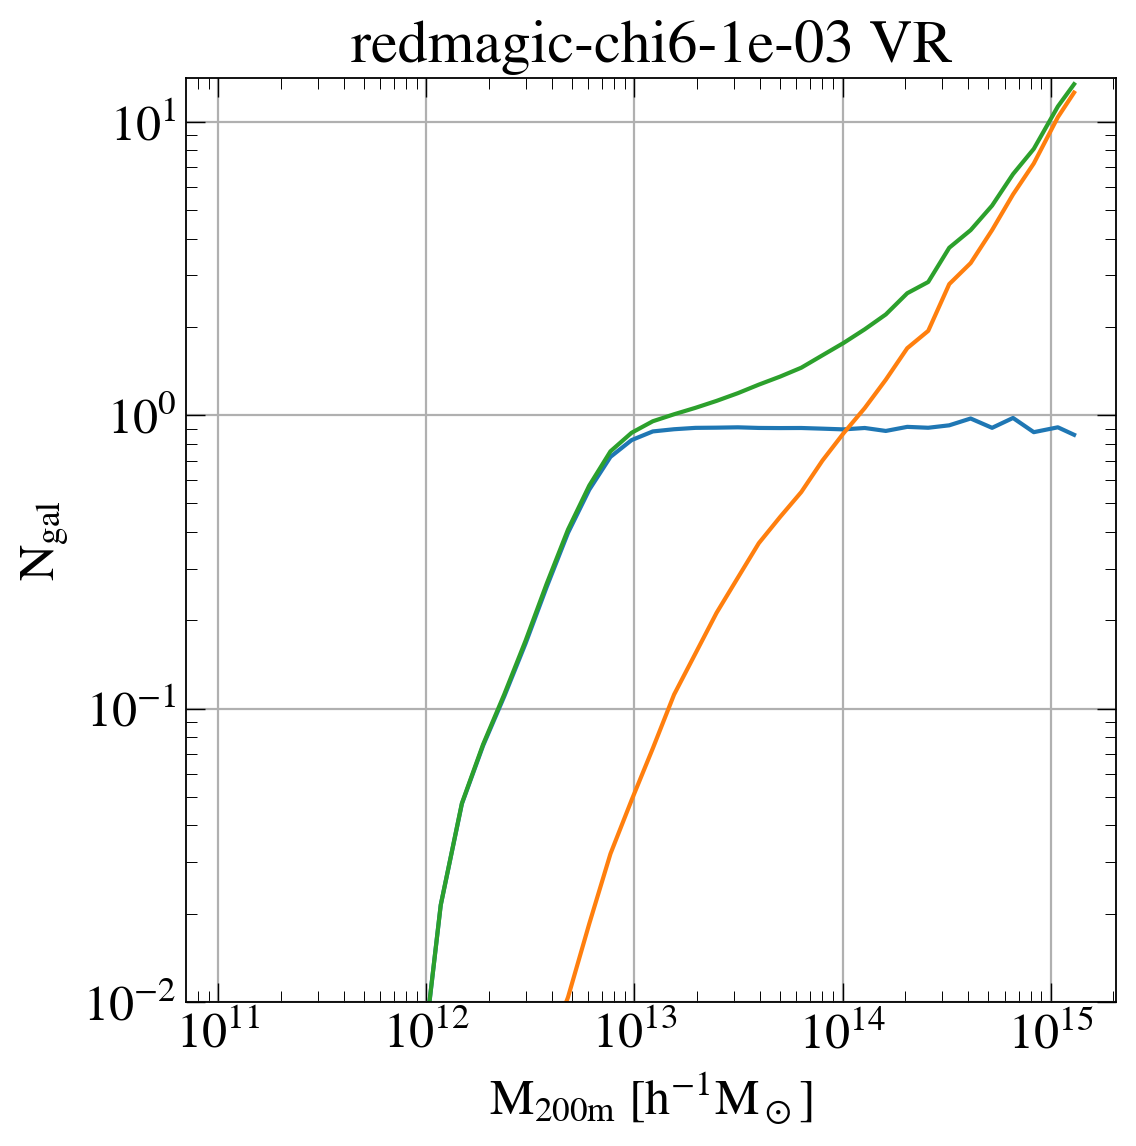

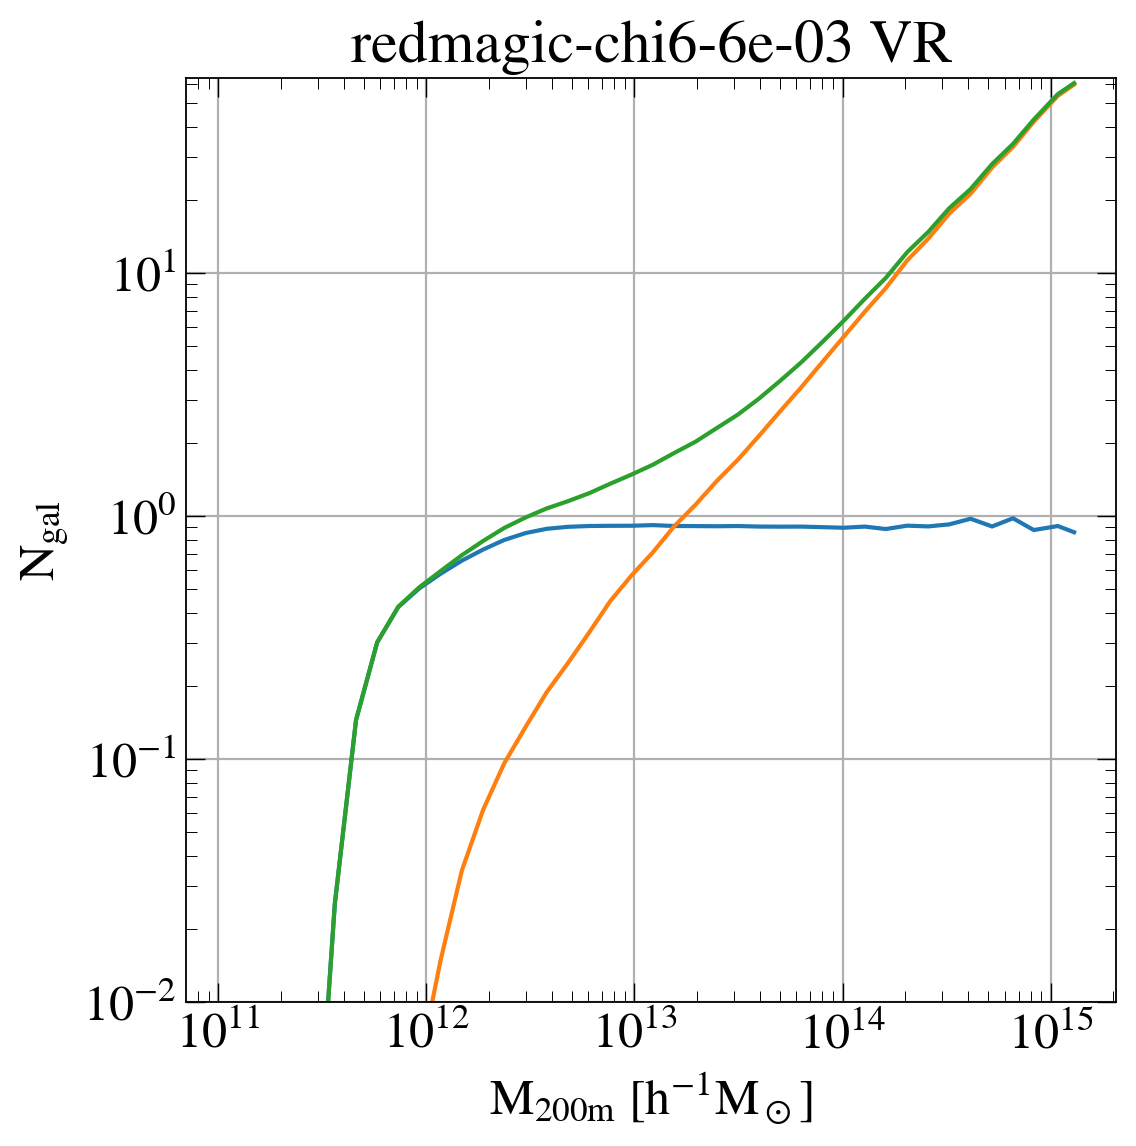

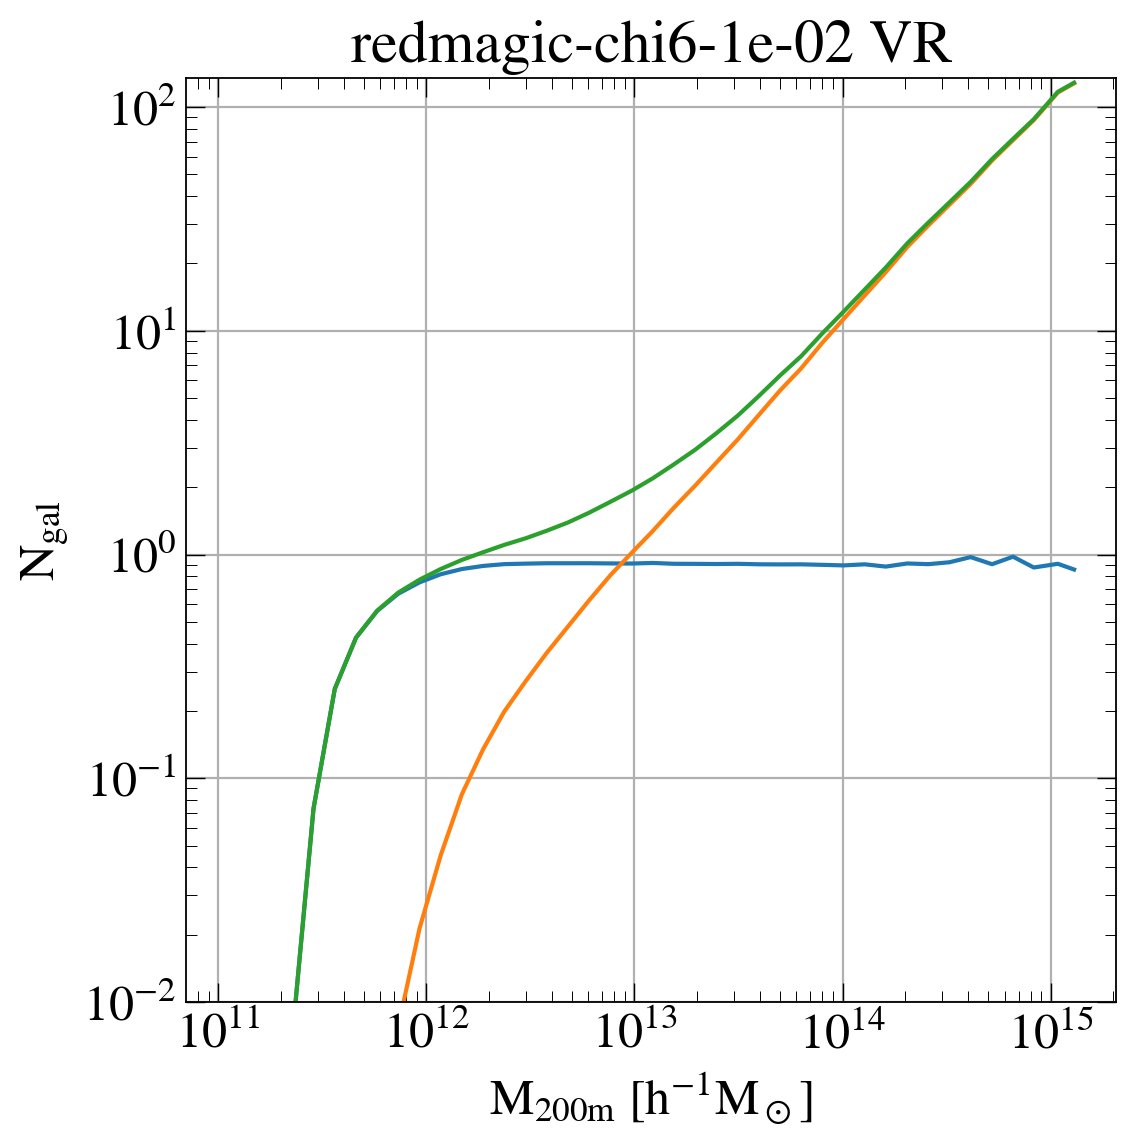

In [6]:
for halo_finder in ['HBT', 'VR']:
    for den_wanted in [1e-3, 6e-3, 1e-2]: 
        gal_selection = f'redmagic_chi6_{den_wanted:.0e}'
        plot_hod(halo_finder, gal_selection)

In [ ]:
#plot_hod(halo_finder = 'HBT', den_wanted=1e-3)